Donwload the ephimeres data for Neptune, Uranus, Saturn and Jupiter from the following lik and upload it in the notebook's files before running the code:
https://drive.google.com/drive/folders/1jTIP4iSCrfoqdKXt4sUcwocLxYqIx8uG?usp=sharing

In [1]:
import numpy as np
import scipy.optimize as sc
import math
from astroquery.jplhorizons import Horizons
from astropy.time import Time

## On importe les Ephemeris des corps important sur la trajectoire d'Uranus

In [2]:
# On importe la position des 4 planètes
neptune = Horizons(id="8", location="@sun", epochs={'start': "1800-01-02", 'stop': "2021-07-12",'step': '30d'}, id_type=None).vectors()
uranus = Horizons(id="7", location="@sun", epochs={'start': "1800-01-02", 'stop': "2021-07-12",'step': '30d'}, id_type=None).vectors()
saturne = Horizons(id="6", location="@sun", epochs={'start': "1800-01-02", 'stop': "2021-07-12",'step': '30d'}, id_type=None).vectors()
jupiter = Horizons(id="5", location="@sun", epochs={'start': "1800-01-02", 'stop': "2021-07-12",'step': '30d'}, id_type=None).vectors()

Neptune = np.stack([np.array(neptune[:]["x"]),np.array(neptune[:]["y"]),np.array(neptune[:]["z"])],axis=1)
Uranus = np.stack([np.array(uranus[:]["x"]),np.array(uranus[:]["y"]),np.array(uranus[:]["z"])],axis=1)
Saturn = np.stack([np.array(saturne[:]["x"]),np.array(saturne[:]["y"]),np.array(saturne[:]["z"])],axis=1)
Jupiter = np.stack([np.array(jupiter[:]["x"]),np.array(jupiter[:]["y"]),np.array(jupiter[:]["z"])],axis=1)

# On importe les vitesses d'uranus
Uv = np.stack([np.array(uranus[:]["vx"]),np.array(uranus[:]["vy"]),np.array(uranus[:]["vz"])],axis=1)
Uv=Uv*365.24218750 # Convertir de AU/Jour en AU/an

## On calcule notre variable V avec les vraies valeurs pour voir si on est correcte sur l'intervalle de temps utilisé

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
Time=np.array(range(2698))
Time=Time/12+1800
T=Neptune-Uranus

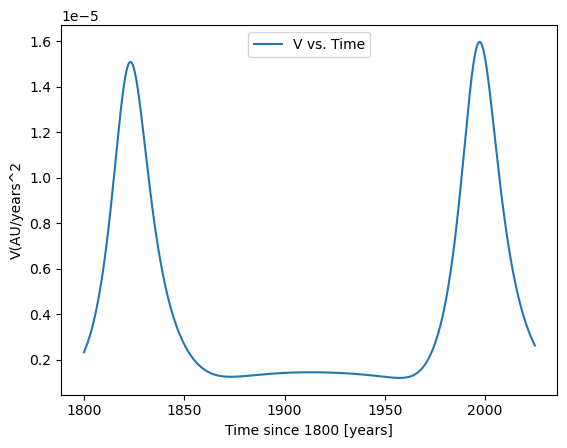

In [4]:
# Ça c'est la partie où ce serait cool d'inclure nos valeurs du simulateur
from scipy.constants import G
G=G*(365.24218750*86400)**2/(149597870700)**3 #Conversion de kg(AU)^3/(année)^2
M_N=1.024e26

# Calcul de V en utilisant Les valeurs de Neptune pour vérifier 
# si le bon graphique peut être obtenu

V1=Neptune-Uranus

Nx,Ny,Nz=Neptune.T
Ux,Uy,Uz=Uranus.T

Vv2=((Nx-Ux)**2+(Ny-Uy)**2+(Nz-Uz)**2)**(3/2) #10^3

V2= np.tile(Vv2, (3,1))
V2=np.transpose(V2)

Vv3=((Nx)**2+(Ny)**2+(Nz)**2)**(3/2) #10^3

V3= np.tile(Vv3, (3,1))
V3=np.transpose(V3)

V=G*M_N*(V1/V2-Neptune/V3)
Vx,Vy,Vz=V.T
V_mag=((Vx)**2+(Vy)**2+(Vz)**2)**(1/2)
plt.plot(Time,V_mag,label="V vs. Time")

plt.xlabel("Time since 1800 [years]")
plt.ylabel("V(AU/years^2")
plt.legend(loc="upper center")
plt.show()


## Maintenant on calcul V sans avoir cette information (J'pas sûr de comprendre la méthode si tu veux essayer de comprendre Phil j'serais vraiment content)

In [5]:
#On compute la variable V en utilisant la méthode RHS (C'est quoi V tabarnack)

M_S=1.989e30 #Masse du Soleil
M_U=8.681e25 #Masse d'Uranus
M_St=5.683e26 #Masse de Saturne
M_J=1.898e27 #Masse de Jupiter

#############
#Deuxième Terme
#############

Vv23=((Ux)**2+(Uy)**2+(Uz)**2)**(1/2)
V2_2_3= np.tile(Vv23, (3,1))
V2_2_3=np.transpose(V2_2_3)

V2_2=G*(M_S+M_U)*Uranus/(V2_2_3**3)

############
#Troisième Terme
############

#Saturn
Sx,Sy,Sz=Saturn.T

Sv2=((Sx-Ux)**2+(Sy-Uy)**2+(Sz-Uz)**2)**(3/2)
S2= np.tile(Sv2, (3,1))
S2=np.transpose(S2)

Sv3=((Sx)**2+(Sy)**2+(Sz)**2)**(3/2)
S3= np.tile(Sv3, (3,1))
S3=np.transpose(S3)

S=G*M_St*((Saturn-Uranus)/S2-Saturn/S3)

#Jupiter
Jx,Jy,Jz=Jupiter.T

Jv2=((Jx-Ux)**2+(Jy-Uy)**2+(Jz-Uz)**2)**(3/2)
J2= np.tile(Jv2, (3,1))
J2=np.transpose(J2)

Jv3=((Jx)**2+(Jy)**2+(Jz)**2)**(3/2)
J3= np.tile(Jv3, (3,1))
J3=np.transpose(J3)

J=G*M_J*((Jupiter-Uranus)/J2-Jupiter/J3)


V2_3=J+S

In [6]:
# On obtient l'accélération d'Uranus en utilisant la 
#méthode "Five-point stencil" du vecteur de vitesse

h=30/365.24218750 # L'intervalle de temps entre deux points consécutifs en année
XX=np.zeros(2698)
V2_1=np.tile(XX,(3,1))

V2_1=np.transpose(V2_1)
for i in range(2696):
    if i==0:
      continue
    if i==1:
      continue
    V2_1[i]=1/(12*h)*(Uv[i-2]-8*Uv[i-1]+8*Uv[i+1]-Uv[i+2])

#On hardcode les deux premières valeurs
V2_1[0]=V2_1[2]
V2_1[1]=V2_1[2]
V2_1[2697]=V2_1[2695]
V2_1[2696]=V2_1[2695]

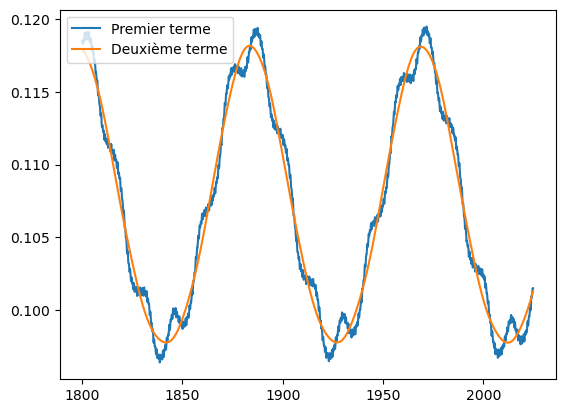

In [7]:
# On prend les coordonnées du premier terme de V2
V21x,V21y,V21z=V2_1.T
Vr_magg=((V21x)**2+(V21y)**2+(V21z)**2)**(1/2)
plt.plot(Time,Vr_magg,label="Premier terme")

# On prend les coordonnées du deuxième terme de V2
V22x,V22y,V22z=V2_2.T
Vr_maggg=((V22x)**2+(V22y)**2+(V22z)**2)**(1/2)
plt.plot(Time,Vr_maggg,label="Deuxième terme")

# On prend les coordonnées du troisième terme de V2
V23x,V23y,V23z=V2_3.T
Vr_magggg=((V23x)**2+(V23y)**2+(V23z)**2)**(1/2)
# plt.plot(Time,Vr_magggg,label="Terms with Jupiter and Saturn")

plt.legend(loc="upper left")
plt.show()

## Ce bout là je sais pas ce qu'il essaye de représenter

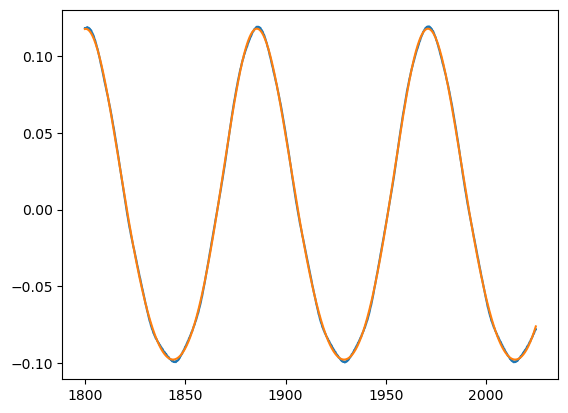

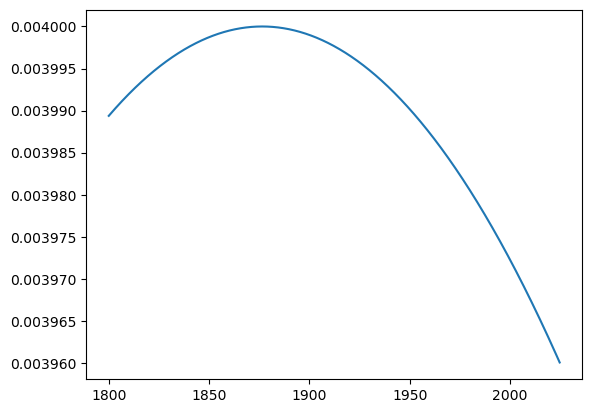

In [8]:
plt.plot(Time,V21x)
plt.plot(Time,-V22x)
plt.show()
Y=0.0143*np.sin(-0.00050416*Time+103.0478)-0.0103
plt.plot(Time,Y)
plt.show()

## On utlise le curvefit pour obtenir une meilleure précision sur le terme de l'accélération

On va utiliser le curvefit sur le vecteur de vitesse d'Uranus et ensuite le dériver pour obtenir l'accélération

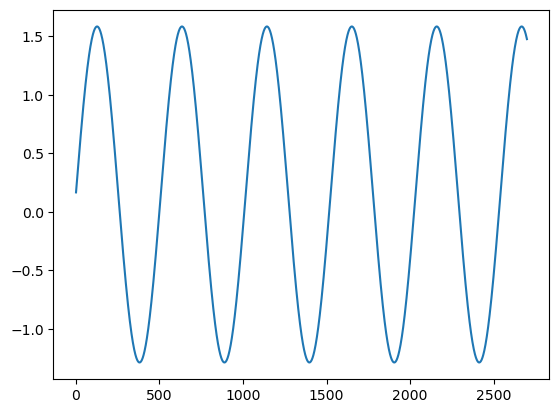

In [9]:
from scipy.optimize import curve_fit

yx,yy,yz=Uv.T #Separating out the x,y, and z coordinates of the Uranus velocity

#Guess values
guess_mean = np.mean(yx) #off-set:d 0.1573576483417295
# guess_std = 3*np.std(Vr_magg)/(2**0.5)/(2**0.5) #amplitude
guess_phase = 89
guess_freq = 0.00103092784*12
guess_amp = (max(yx)-min(yx))/2 # 1.4298978352188507

# define the true objective function
def objective(x, a, b, c, d, e, f, g, h, i, j):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + (f * x**6)+(g * x**7)+(h * x**8)+(i * x**9)+j

x=np.arange(1,2699)

plt.plot(x,guess_amp*np.sin(guess_freq*x)+guess_mean)

# curve fit
popt, _ = curve_fit(objective, x, yx)
# summarize the parameter values
a, b, c, d, e, f, g, h, i, j = popt
# plot input vs output
#plt.scatter(x, y)

y_line = objective(x, a, b, c, d, e, f, g, h, i, j)

# plt.plot(x, y_line, '--', color='red')
#plt.plot(x,25000*yx)

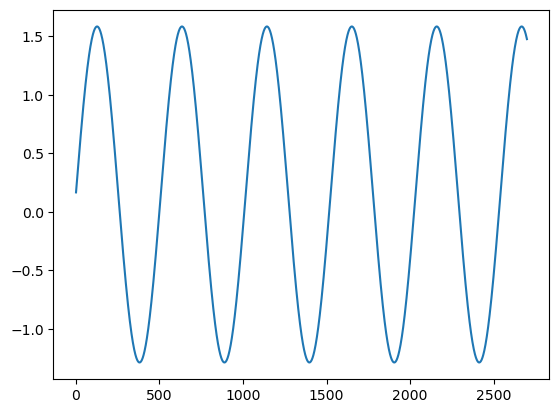

In [10]:
from scipy.optimize import curve_fit

yx,yy,yz=Uv.T # Séparation des coordonnées du vecteur vitesse d'Uranus

#Guess des valeurs
guess_mean = np.mean(yx) #off-set:d 0.1573576483417295
guess_phase = 89
guess_freq = 0.00103092784*12
guess_amp = (max(yx)-min(yx))/2 # 1.4298978352188507

# Définition d'une fonction de degré 9
def degree9(x, a, b, c, d, e, f, g, h, i, j):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + (f * x**6)+(g * x**7)+(h * x**8)+(i * x**9)+j

x=np.arange(1,2699)

plt.plot(x,guess_amp*np.sin(guess_freq*x)+guess_mean)

# curve fit
popt, _ = curve_fit(degree9, x, yx)
a, b, c, d, e, f, g, h, i, j = popt
y_line = degree9(x, a, b, c, d, e, f, g, h, i, j)

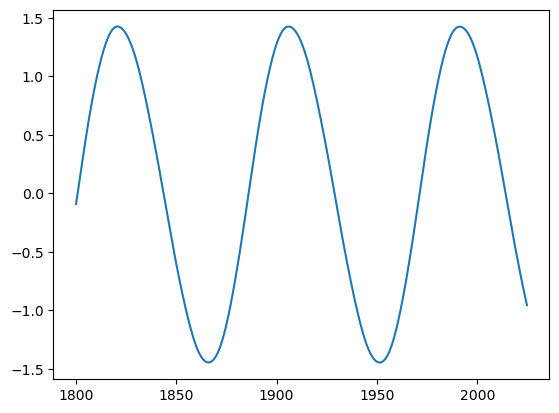

In [11]:
plt.plot(Time,yx)
plt.show()

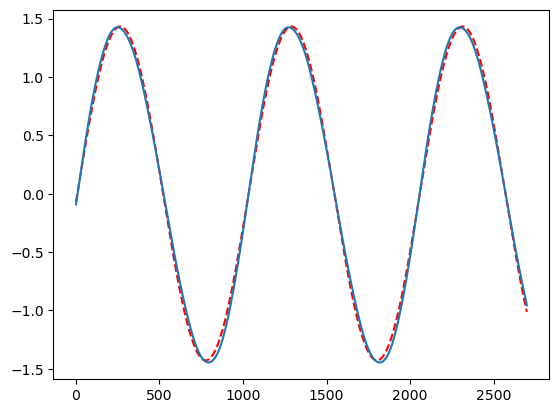

In [12]:
#Guess des valeurs
guess_mean = np.mean(Vr_magg) #off-set:d
guess_std = 3*np.std(Vr_magg)/(2**0.5)/(2**0.5) #amplitude
guess_phase = 80
guess_freq = 0.00655
guess_amp = 0.012

Guess=[guess_amp,guess_freq,guess_phase,guess_mean]
from numpy import sin
def objective(x, a, f, p, o):
	return a*sin(f*x+p) + o

x=np.arange(1,2699)
yx,yy,yz=Uv.T

# curve fit
popt, _ = curve_fit(objective, x, yx, Guess)

# summarize the parameter values
a, b, c, d = popt

# calculate the output for the range
y_line = objective(x, a, b, c, d)

# create a line plot for the mapping function
plt.plot(x, y_line, '--', color='red')

# plt.show()
plt.plot(x,yx)

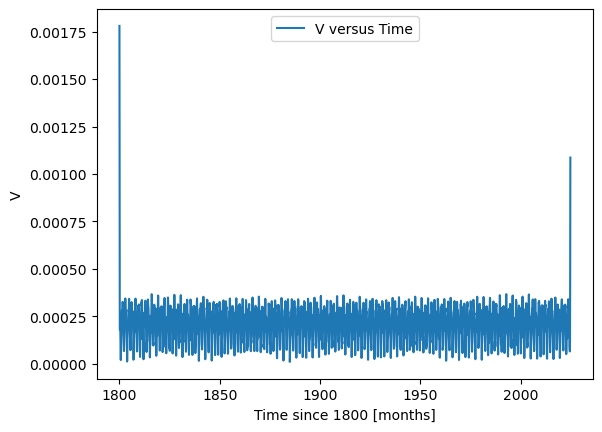

In [13]:
V_RHS=V2_1+V2_2-V2_3
Vrx,Vry,Vrz=V_RHS.T
Vr_mag=((Vrx)**2+(Vry)**2+(Vrz)**2)**(1/2)
plt.plot(Time,Vr_mag,label="V versus Time")

plt.xlabel("Time since 1800 [months]")
plt.ylabel("V")
plt.legend(loc="upper center")
plt.show()

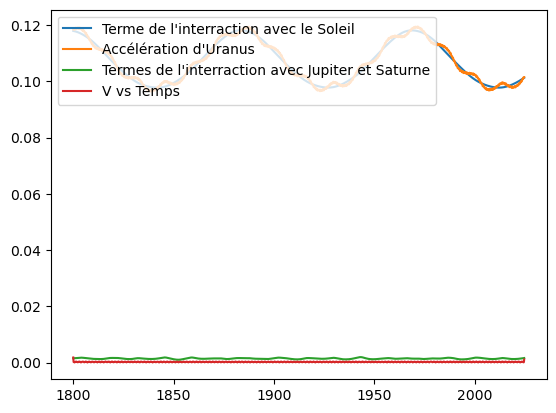

In [14]:
Vrxx,Vryy,Vrzz=V2_2.T
Vr_magg=((Vrxx)**2+(Vryy)**2+(Vrzz)**2)**(1/2)
plt.plot(Time,Vr_magg,label="Terme de l'interraction avec le Soleil")

V21x,V21y,V21z=V2_1.T
Vr_maggg=((V21x)**2+(V21y)**2+(V21z)**2)**(1/2)
plt.plot(Time,Vr_maggg,label="Accélération d'Uranus")

V23x,V23y,V23z=V2_3.T
Vr_magggg=((V23x)**2+(V23y)**2+(V23z)**2)**(1/2)
plt.plot(Time,Vr_magggg,label="Termes de l'interraction avec Jupiter et Saturne")

plt.plot(Time,Vr_mag,label="V vs Temps")
plt.legend(loc="upper left")
plt.show()

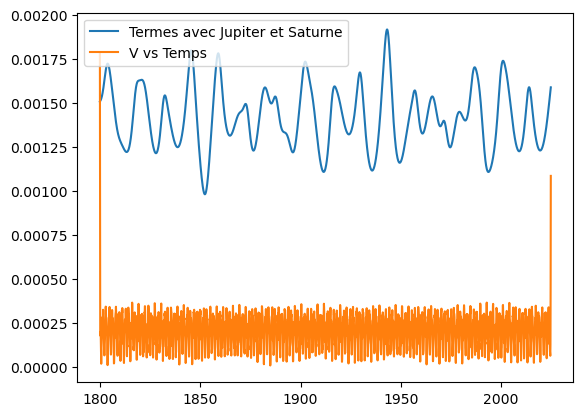

In [15]:
plt.plot(Time,Vr_magggg,label="Termes avec Jupiter et Saturne")

plt.plot(Time,Vr_mag,label="V vs Temps")
plt.legend(loc="upper left")
plt.show()

## Moving on from V

Text(0, 0.5, '$x_t$')

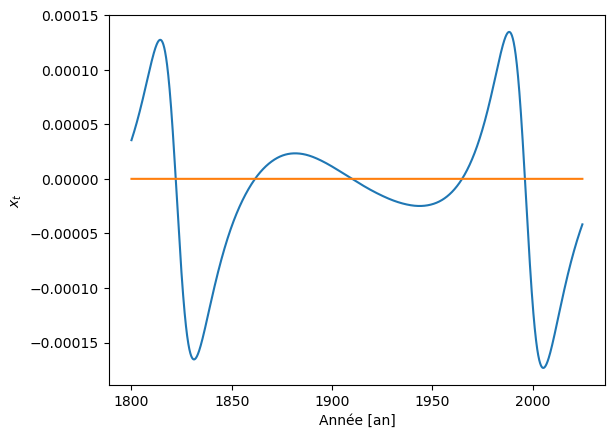

In [16]:
Z=np.zeros(2698)
Z=np.tile(Z,(3,1))
Z=np.transpose(Z)
for i in range(2698):
  Z[i,2]=1


p_t=np.cross(Z,Uranus)
px,py,pz=p_t.T
x_t=Vx*px+Vy*py+Vz*pz

plt.plot(Time,x_t)

Zero=np.zeros(2698)
Zero=np.array(Zero)
plt.plot(Time,Zero)
plt.xlabel("Année [an]")
plt.ylabel("$x_t$")

## Là il essaye de trouver la période, mais sont code est fucking deg faudrait changer ça

In [17]:
#Finding the roots of x_t
C1=0
a=0
O1=0
b=0
C2=0
t=0
for i in range(2695):

  if x_t[i]<0 and x_t[i+1]>0:
    if t==0:
      C1=Time[i]
      t=t+1
    elif t==1:
      a=Time[i]
      t=t+1
    if t==2:
      O1=Time[i]
      t=t+1
    elif t==3:
      b=Time[i]
      t=t+1
    elif t==5:
      C2=Time[i]
      t=t+1


  if x_t[i]>0 and x_t[i+1]<0:
    if t==0:
      C1=Time[i]
      t=t+1
    elif t==1:
      a=Time[i]
      t=t+1
    if t==2:
      O1=Time[i]
      t=t+1
    elif t==3:
      b=Time[i]
      t=t+1
    elif t==4:
      C2=Time[i]
      t=t+1



print("First Conjunction: ",C1)
#print(a)
print("First opposition: ",b)
#print(b)
print("Second Conunction: ",C2)

C=C2-C1
C=(1-5/365.24218750)*C

print("The Synodic Period of Neptune with respect to Uranus is :",C," years")

First Conjunction:  1822.0
First opposition:  1909.9166666666667
Second Conunction:  1996.0833333333333
The Synodic Period of Neptune with respect to Uranus is : 171.70021140367754  years


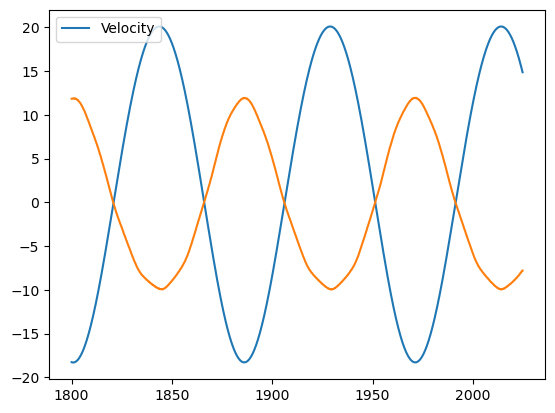

In [18]:
plt.plot(Time,Ux, label="Velocity")
plt.plot(Time,100*V21x)
plt.legend(loc="upper left")
#This indicates that I am calculating the correct acceleration of Uranus
#It's just that its magnitude is extremely small
plt.show()

## Ici on recalcul le graph du début mais avec le V qu'on a compute tout au long de la méthode

Text(0, 0.5, 'e_t')

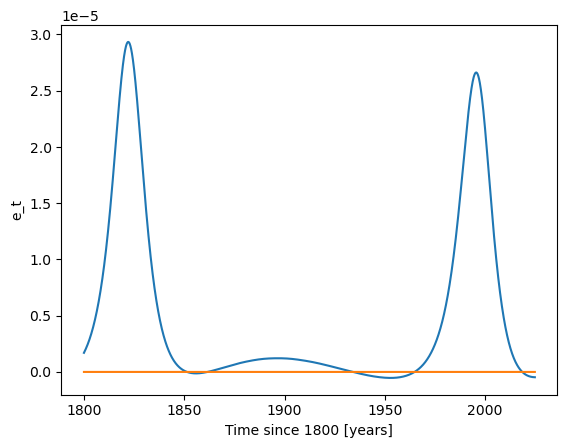

In [19]:
Nu=np.cross(Uranus,Uv)

Nux,Nuy,Nuz=Nu.T
E_t=Vx*Nux+Vy*Nuy+Vz*Nuz
plt.plot(Time,E_t)
plt.plot(Time,Zero)
plt.xlabel("Time since 1800 [years]")
plt.ylabel("e_t")

## Encore une fois sa fonction est dégueulasse va falloir changer ça

In [20]:
#Finding the roots of E_t
D1=0
c=0
E1=0
d=0
D2=0
t=0
for i in range(2695):

  if E_t[i]<0 and E_t[i+1]>0:
    if t==0:
      D1=Time[i]
      t=t+1
    elif t==1:
      c=Time[i]
      t=t+1
    if t==2:
      E1=Time[i]
      t=t+1
    elif t==3:
      d=Time[i]
      t=t+1
    elif t==5:
      D2=Time[i]
      t=t+1


  if E_t[i]>0 and E_t[i+1]<0:
    if t==0:
      D1=Time[i]
      t=t+1
    elif t==1:
      c=Time[i]
      t=t+1
    if t==2:
      E1=Time[i]
      t=t+1
    elif t==3:
      d=Time[i]
      t=t+1
    elif t==4:
      D2=Time[i]
      t=t+1

D=D2-D1
D=(1-5/365.24218750)*D
print("The sidereal period for Uranus is: ",D)


The sidereal period for Uranus is:  164.79603823091142


In [21]:
#Calculating the semi-major axis using Kepler's third law
a_u=D**(2/3)
print("Uranus's semi-major axis in AU is:",a_u)

Uranus's semi-major axis in AU is: 30.058306684492393


In [22]:
#Finding the Mass of Neptune:
VVV=V1/V2-Neptune/V3
VVVx,VVVy,VVVz=VVV.T
VVV_mag=((VVVx)**2+(VVVy)**2+(VVVz)**2)**(1/2)

#This won't be a single value but an array of values
Mass_N=V_mag/(VVV_mag*G)

#We print the average of these values
print("The Mass of Neptune is: ",np.sum(Mass_N)/2698)

The Mass of Neptune is:  1.0240000000000001e+26


## Après si on veut faire "comme Le Verrier" on peut juste utiliser la loi de Kepler pour guess la position de Neptune à une date donnée

C'est pas mal ça le plus dur c'est de comprendre ces calculs un peu fucky en soit la méthode est assez cool et élégante. Ce sera pas trop sorcier à expliquer dans le rapport pis la présentation pis je pense qu'on a assez de stock à discuter. Avec sa méthode je ne pense pas qu'on a besoin de la simulation. Si on veut pimper un peu son analyse faudrait rajouter l'effet des 4 autres planètes. On le fera si on a du temps ou au pire après le 26 pour la présentation. Dites moi ce que vous en pensez.